In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.arima_model import ARIMA
import itertools

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

###  Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.


In [2]:
#Загрузка данных  и ресемплинг
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data_m = data.resample('M').mean()
data_m.head(2)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714


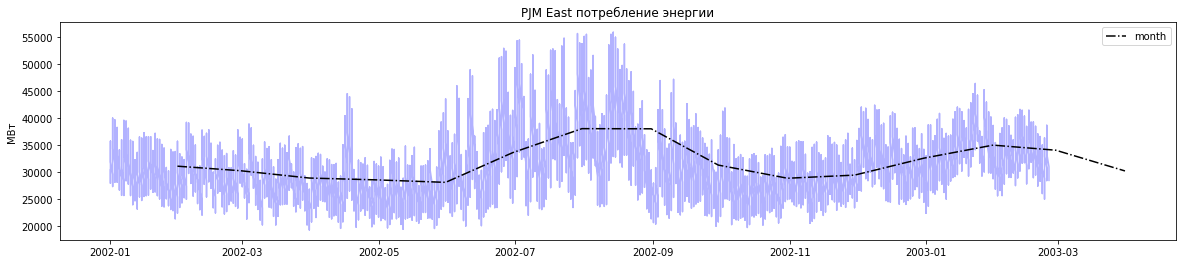

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.title('PJM East потребление энергии')
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

### Подберите параметры модели SARIMAX для этого ряда.

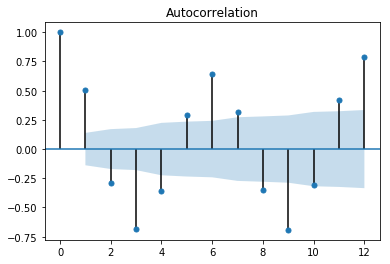

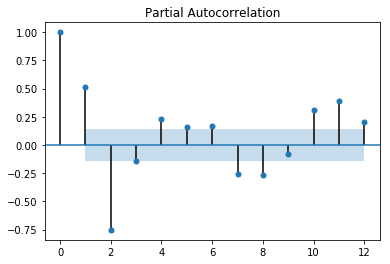

In [4]:
#plt.figure(figsize=(12,4))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=12)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=12)
plt.show()

Полученная оценка автокорреляции месячной модели по исходному ряду и первым разностям показывает, что есть значительная автокорреляция с лагом в 12 месяцев и значительная корреляция по первым трем лагам.

In [5]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA are:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA are:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [6]:
best_param =[]
best_seasonal = []
best_AIC = 9999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-24],order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            if results.aic < best_AIC:
                best_AIC = results.aic
                best_param = param
                best_seasonal = param_seasonal
            #print(f'ARIMA{param}x{param_seasonal}3 - AIC:{results.aic:.2f}')
        except:
            continue
print(f'Best parametrs ARIMA{best_param}x{best_seasonal}3 - AIC:{best_AIC:.2f}')

Best parametrs ARIMA(1, 1, 2)x(1, 2, 2, 12)3 - AIC:2225.96


Лучшие результаты на месячных данных параметры модели SARIMA(1,1,2)x(1, 2, 2, 12) - AIC:22225.96 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

In [9]:
#для построения модели используем все данные, кроме последнего года (это будет тестовый набор)
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=[1,1,2],
                                seasonal_order=[1,2,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print(f'AIC: {results_opt.aic:.2f}')

AIC: 2438.81


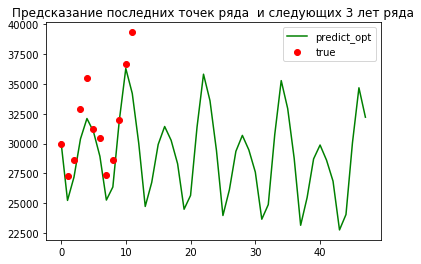

In [14]:
 #делаем предсказание на 3 года от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(48)


plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 3 лет ряда')
plt.legend()

plt.show()

### Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Полученная модель на основе месячных данных более сглажена по сравнению с недельной. 
Для долгосрочных прогнозов это хорошо. Позволяет увидеть картину вцелом. Однако, модель на месячных данных дала более низкие нижние точки. Т.е. первый провал на недельной модели около 27 тыс.ВТ. На месячной модели около 25 тыс и уменьшается во времени. Если посмотрим на факт, то последние нижние точки были на уровне 27.5 тыс.
С точки зрения бизнеса, это не есть хорошо. Например, мы уменьшим мощности согласно прогнозу и получим коллапс. 
Полученая модель хорошо отражает характер поведения, но я бы сгладила нижние пики и еще раз посмотрела, действительно ли имеет место нисходящий тренд.